In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Robot:
    def __init__(self, initial_position):
        self.true_position = initial_position
        self.particles = np.random.normal(initial_position, 2, 1000)  # パーティクルの初期化

    def move(self, distance):
        self.true_position += distance
        self.particles += np.random.normal(distance, 0.5, 1000)  # パーティクルの更新

    def sense(self):
        # 距離センサの単純なモデル
        true_measurement = self.true_position + np.random.normal(0, 1)
        particle_measurements = self.particles + np.random.normal(0, 1, 1000)
        return true_measurement, particle_measurements


In [3]:
def particle_filter(robot, movement, measurements):
    # パーティクルを動かす
    robot.move(movement)

    # 重みの計算
    weights = np.exp(-0.5 * ((robot.particles - measurements) / 1) ** 2)  # センサの精度は1

    # リサンプリング
    indices = np.random.choice(range(1000), 1000, p=weights / np.sum(weights))
    robot.particles = robot.particles[indices]

    # 推定位置の計算
    estimated_position = np.mean(robot.particles)

    return estimated_position


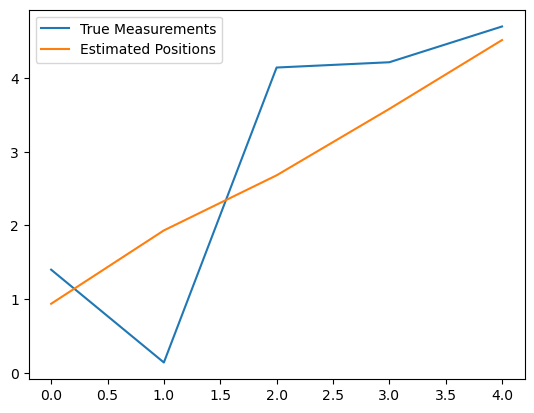

In [4]:
# シミュレーションの設定
np.random.seed(42)
initial_position = 0
robot = Robot(initial_position)
movements = [1, 1, 1, 1, 1]  # 移動のシーケンス
measurements = []

# パーティクルフィルタの実行
estimated_positions = []
for movement in movements:
    true_measurement, particle_measurements = robot.sense()
    measurements.append(true_measurement)
    estimated_position = particle_filter(robot, movement, particle_measurements)
    estimated_positions.append(estimated_position)

# 結果の可視化
plt.plot(range(len(measurements)), measurements, label='True Measurements')
plt.plot(range(len(estimated_positions)), estimated_positions, label='Estimated Positions')
plt.legend()
plt.show()


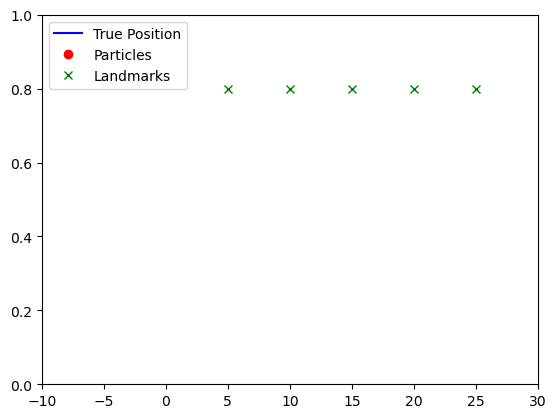

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Robot:
    def __init__(self, initial_position):
        self.true_position = initial_position
        self.particles = np.random.normal(initial_position, 2, 1000)  # パーティクルの初期化

    def move(self, distance):
        self.true_position += distance
        self.particles += np.random.normal(distance, 0.5, 1000)  # パーティクルの更新

    def sense(self, landmarks):
        # センサのモデル
        true_measurement = [self.true_position - landmark + np.random.normal(0, 1) for landmark in landmarks]
        particle_measurements = [self.particles - landmark + np.random.normal(0, 1, 1000) for landmark in landmarks]
        return true_measurement, particle_measurements

# パーティクルフィルタのメイン部分
def particle_filter(robot, movement, measurements):
    robot.move(movement)

    # 重みの計算
    weights = np.exp(-0.5 * ((robot.particles - measurements) / 1) ** 2)  # センサの精度は1

    # リサンプリング
    indices = np.random.choice(range(1000), 1000, p=weights / np.sum(weights))
    robot.particles = robot.particles[indices]

    # 推定位置の計算
    estimated_position = np.mean(robot.particles)

    return estimated_position

# アニメーションの初期化
fig, ax = plt.subplots()
ax.set_xlim(-10, 30)
ax.set_ylim(0, 1)
true_line, = ax.plot([], [], label='True Position', color='blue')
particle_line, = ax.plot([], [], 'ro', label='Particles')
landmarks = [5, 10, 15, 20, 25]
landmark_points, = ax.plot(landmarks, [0.8]*len(landmarks), 'gx', label='Landmarks')

def init():
    true_line.set_data([], [])
    particle_line.set_data([], [])
    landmark_points.set_data(landmarks, [0.8]*len(landmarks))
    return true_line, particle_line, landmark_points

# アニメーションの更新
def update(frame):
    movement = 1
    true_measurement, particle_measurements = robot.sense(landmarks)
    estimated_position = particle_filter(robot, movement, particle_measurements)

    robot_positions = np.repeat(robot.true_position, 1000)
    true_line.set_data([robot_positions, robot_positions], [0, 1])
    particle_line.set_data([robot.particles, robot.particles], [0, 1])

    return true_line, particle_line

# ロボットの初期化
np.random.seed(42)
initial_position = 0
robot = Robot(initial_position)

# アニメーションの作成
ani = FuncAnimation(fig, update, frames=range(5), init_func=init, blit=True)
plt.legend()
plt.show()


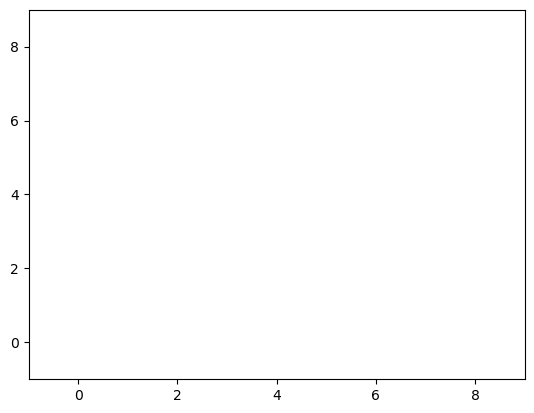

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import animation

# ロボットの初期位置
initial_pose = np.array([0, 0, 0])

# ランドマークの位置
landmarks = np.array([[2, 2], [2, 6], [6, 6], [6, 2]])

# パーティクル数
num_particles = 1000

# パーティクルの初期配置
particles = np.random.rand(num_particles, 3) * np.array([8, 8, 2 * np.pi]) - np.array([0, 0, np.pi])

# パーティクルの重み
weights = np.ones(num_particles) / num_particles

# パーティクルの動きに関するノイズの標準偏差
forward_noise = 0.1
turn_noise = 0.1
sensor_noise = 0.1

# ロボットの動き
def move(particles, delta, noise):
    delta += np.random.normal(0, noise, particles.shape)
    particles[:, 0] += delta[0] * np.cos(particles[:, 2])
    particles[:, 1] += delta[0] * np.sin(particles[:, 2])
    particles[:, 2] += delta[1]
    particles[:, 2] %= 2 * np.pi

# 距離の計測
def sense(true_pose, landmarks, noise):
    true_dists = np.sqrt((landmarks[:, 0] - true_pose[0]) ** 2 + (landmarks[:, 1] - true_pose[1]) ** 2)
    return true_dists + np.random.normal(0, noise, len(landmarks))

# 尤度の計算
def calculate_likelihood(particles, measured_dists, noise):
    true_dists = np.sqrt(particles[:, 0] ** 2 + particles[:, 1] ** 2)
    probs = np.exp(-0.5 * ((true_dists - measured_dists) / noise) ** 2)
    return probs / np.sum(probs)

# リサンプリング
def resampling(particles, weights):
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    return particles[indices], np.ones(num_particles) / num_particles

# アニメーションの初期化
fig, ax = plt.subplots()
ax.set_xlim(-1, 9)
ax.set_ylim(-1, 9)
particles_plot, = ax.plot([], [], 'r.', markersize=5)
landmarks_plot, = ax.plot([], [], 'bo')
ellipse_plot = Ellipse((0, 0), 0, 0, alpha=0.3, color='gray')
ax.add_patch(ellipse_plot)

# アニメーションの更新
def update(frame):
    global particles, weights

    # ロボットの動き
    move(particles, np.array([0.2, 0.05]), np.array([forward_noise, turn_noise]))

    # センサの更新
    true_dists = sense(initial_pose, landmarks, sensor_noise)

    # 尤度の計算
    weights = calculate_likelihood(particles, true_dists, sensor_noise)

    # リサンプリング
    particles, weights = resampling(particles, weights)

    # アニメーションの描画
    particles_plot.set_data(particles[:, 0], particles[:, 1])
    landmarks_plot.set_data(landmarks[:, 0], landmarks[:, 1])

    # 共分散行列の計算
    covariance_matrix = np.cov(particles[:, :2].T, aweights=weights)

    # 共分散行列から楕円の情報を取得
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)

    # 楕円を描画
    ellipse_plot.set_center((np.mean(particles[:, 0]), np.mean(particles[:, 1])))
    ellipse_plot.width = width
    ellipse_plot.height = height
    ellipse_plot.angle = angle

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=range(20), interval=500)

# アニメーションの表示
plt.show()


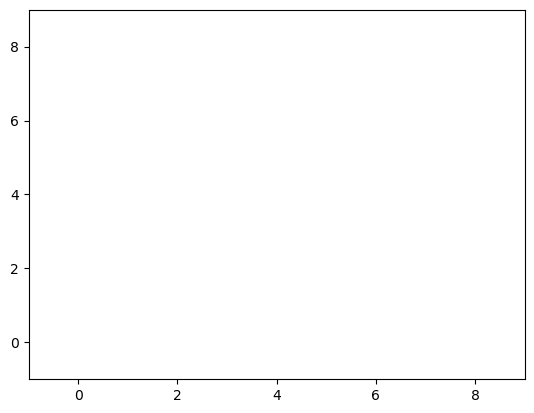

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import animation

# ロボットの初期位置
initial_pose = np.array([0, 0, 0])

# ランドマークの位置
landmarks = np.array([[2, 2], [2, 6], [6, 6], [6, 2]])

# パーティクル数
num_particles = 1000

# パーティクルの初期配置
particles = np.random.rand(num_particles, 3) * np.array([8, 8, 2 * np.pi]) - np.array([0, 0, np.pi])

# パーティクルの重み
weights = np.ones(num_particles) / num_particles

# パーティクルの動きに関するノイズの標準偏差
forward_noise = 0.1
turn_noise = 0.1
sensor_noise = 0.1

# ロボットの動き
def move(particles, delta, noise):
    delta += np.random.normal(0, noise, particles.shape)
    particles[:, 0] += delta[0] * np.cos(particles[:, 2])
    particles[:, 1] += delta[0] * np.sin(particles[:, 2])
    particles[:, 2] += delta[1]
    particles[:, 2] %= 2 * np.pi

# 距離の計測
def sense(true_pose, landmarks, noise):
    true_dists = np.sqrt((landmarks[:, 0] - true_pose[0]) ** 2 + (landmarks[:, 1] - true_pose[1]) ** 2)
    return true_dists + np.random.normal(0, noise, len(landmarks))

# 尤度の計算
def calculate_likelihood(particles, measured_dists, noise):
    true_dists = np.sqrt(particles[:, 0] ** 2 + particles[:, 1] ** 2)
    probs = np.exp(-0.5 * ((true_dists - measured_dists) / noise) ** 2)
    return probs / np.sum(probs)

# リサンプリング
def resampling(particles, weights):
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    return particles[indices], np.ones(num_particles) / num_particles

# アニメーションの初期化
fig, ax = plt.subplots()
ax.set_xlim(-1, 9)
ax.set_ylim(-1, 9)
particles_plot, = ax.plot([], [], 'r.', markersize=5)
landmarks_plot, = ax.plot([], [], 'bo')
ellipse_plot = Ellipse((0, 0), 0, 0, alpha=0.3, color='gray')
ax.add_patch(ellipse_plot)

# アニメーションの更新
def update(frame):
    global particles, weights

    # ロボットの動き
    move(particles, np.array([0.2, 0.05]), np.array([forward_noise, turn_noise]))

    # センサの更新
    true_dists = sense(initial_pose, landmarks, sensor_noise)

    # 尤度の計算
    weights = calculate_likelihood(particles, true_dists, sensor_noise)

    # リサンプリング
    particles, weights = resampling(particles, weights)

    # アニメーションの描画
    particles_plot.set_data(particles[:, 0], particles[:, 1])
    landmarks_plot.set_data(landmarks[:, 0], landmarks[:, 1])

    # 共分散行列の計算
    covariance_matrix = np.cov(particles[:, :2].T, aweights=weights)

    # 共分散行列から楕円の情報を取得
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)

    # 楕円を描画
    ellipse_plot.set_center((np.mean(particles[:, 0]), np.mean(particles[:, 1])))
    ellipse_plot.width = width
    ellipse_plot.height = height
    ellipse_plot.angle = angle

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=range(20), interval=500)

# アニメーションの表示
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape

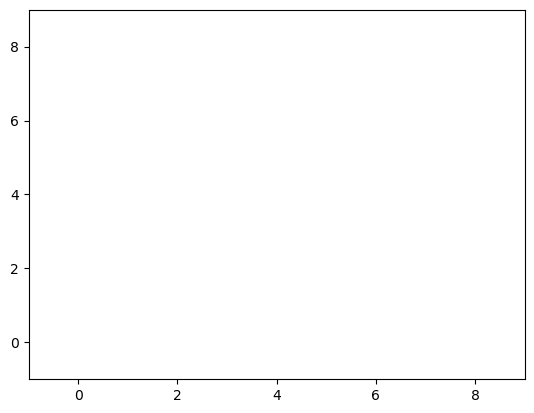

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import animation

# ロボットの初期位置
initial_pose = np.array([0, 0, 0])

# ランドマークの位置
landmarks = np.array([[2, 2], [2, 6], [6, 6], [6, 2]])

# パーティクル数
num_particles = 1000

# パーティクルの初期配置
particles = np.random.rand(num_particles, 3) * np.array([8, 8, 2 * np.pi]) - np.array([0, 0, np.pi])

# パーティクルの重み
weights = np.ones(num_particles) / num_particles

# パーティクルの動きに関するノイズの標準偏差
forward_noise = 0.1
turn_noise = 0.1
sensor_noise = 0.1

# ロボットの動き
def move(particles, delta, noise):
    delta += np.random.normal(0, noise, particles.shape)
    particles[:, 0] += delta[0] * np.cos(particles[:, 2])
    particles[:, 1] += delta[0] * np.sin(particles[:, 2])
    particles[:, 2] += delta[1]
    particles[:, 2] %= 2 * np.pi

# 距離の計測
def sense(true_pose, landmarks, noise):
    true_dists = np.sqrt((landmarks[:, 0] - true_pose[0]) ** 2 + (landmarks[:, 1] - true_pose[1]) ** 2)
    return true_dists + np.random.normal(0, noise, len(landmarks))

# 尤度の計算
def calculate_likelihood(particles, measured_dists, noise):
    true_dists = np.sqrt(particles[:, 0] ** 2 + particles[:, 1] ** 2)
    probs = np.exp(-0.5 * ((true_dists - measured_dists) / noise) ** 2)
    return probs / np.sum(probs)

# リサンプリング
def resampling(particles, weights):
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    return particles[indices], np.ones(num_particles) / num_particles

# アニメーションの初期化
fig, ax = plt.subplots()
ax.set_xlim(-1, 9)
ax.set_ylim(-1, 9)
particles_plot, = ax.plot([], [], 'r.', markersize=5)
landmarks_plot, = ax.plot([], [], 'bo')
ellipse_plot = Ellipse((0, 0), 0, 0, alpha=0.3, color='gray')
ax.add_patch(ellipse_plot)

# アニメーションの更新
def update(frame):
    global particles, weights

    # ロボットの動き
    move(particles, np.array([0.2, 0.05]), np.array([forward_noise, turn_noise]))

    # センサの更新
    true_dists = sense(initial_pose, landmarks, sensor_noise)

    # 尤度の計算
    weights = calculate_likelihood(particles, true_dists, sensor_noise)

    # リサンプリング
    particles, weights = resampling(particles, weights)

    # アニメーションの描画
    particles_plot.set_data(particles[:, 0], particles[:, 1])
    landmarks_plot.set_data(landmarks[:, 0], landmarks[:, 1])

    # 共分散行列の計算
    covariance_matrix = np.cov(particles[:, :2].T, aweights=weights)

    # 共分散行列から楕円の情報を取得
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)

    # 楕円を描画
    ellipse_plot.set_center((np.mean(particles[:, 0]), np.mean(particles[:, 1])))
    ellipse_plot.width = width
    ellipse_plot.height = height
    ellipse_plot.angle = angle

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=range(20), interval=500)

from IPython.display import HTML
HTML(ani.to_jshtml())


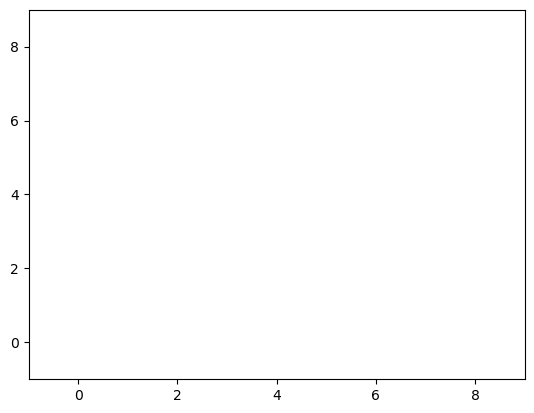

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import animation

# ロボットの初期位置
initial_pose = np.array([0, 0, 0])

# ランドマークの位置
landmarks = np.array([[2, 2], [2, 6], [6, 6], [6, 2]])

# パーティクル数
num_particles = 1000

# パーティクルの初期配置
particles = np.random.rand(num_particles, 3) * np.array([8, 8, 2 * np.pi]) - np.array([0, 0, np.pi])

# パーティクルの重み
weights = np.ones(num_particles) / num_particles

# パーティクルの動きに関するノイズの標準偏差
forward_noise = 0.1
turn_noise = 0.1
sensor_noise = 0.1

# ロボットの動き
def move(particles, delta, noise):
    delta += np.random.normal(0, noise, particles.shape)
    particles[:, 0] += delta[0] * np.cos(particles[:, 2])
    particles[:, 1] += delta[0] * np.sin(particles[:, 2])
    particles[:, 2] += delta[1]
    particles[:, 2] %= 2 * np.pi

# 距離の計測
def sense(true_pose, landmarks, noise):
    true_dists = np.sqrt((landmarks[:, 0] - true_pose[0]) ** 2 + (landmarks[:, 1] - true_pose[1]) ** 2)
    return true_dists + np.random.normal(0, noise, len(landmarks))

# 尤度の計算
def calculate_likelihood(particles, measured_dists, noise):
    true_dists = np.sqrt(particles[:, 0] ** 2 + particles[:, 1] ** 2)
    probs = np.exp(-0.5 * ((true_dists - measured_dists) / noise) ** 2)
    return probs / np.sum(probs)

# リサンプリング
def resampling(particles, weights):
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    return particles[indices], np.ones(num_particles) / num_particles

# アニメーションの初期化
fig, ax = plt.subplots()
ax.set_xlim(-1, 9)
ax.set_ylim(-1, 9)
particles_plot, = ax.plot([], [], 'r.', markersize=5)
landmarks_plot, = ax.plot([], [], 'bo')
ellipse_plot = Ellipse((0, 0), 0, 0, alpha=0.3, color='gray')
ax.add_patch(ellipse_plot)

# アニメーションの更新
def update(frame):
    global particles, weights

    # ロボットの動き
    move(particles, np.array([0.2, 0.05]), np.array([forward_noise, turn_noise]))

    # センサの更新
    true_dists = sense(initial_pose, landmarks, sensor_noise)

    # 尤度の計算
    weights = calculate_likelihood(particles, true_dists, sensor_noise)

    # リサンプリング
    particles, weights = resampling(particles, weights)

    # アニメーションの描画
    particles_plot.set_data(particles[:, 0], particles[:, 1])
    landmarks_plot.set_data(landmarks[:, 0], landmarks[:, 1])

    # 共分散行列の計算
    covariance_matrix = np.cov(particles[:, :2].T, aweights=weights)

    # 共分散行列から楕円の情報を取得
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)

    # 楕円を描画
    ellipse_plot.set_center((np.mean(particles[:, 0]), np.mean(particles[:, 1])))
    ellipse_plot.width = width
    ellipse_plot.height = height
    ellipse_plot.angle = angle

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=range(20), interval=500)

# アニメーションの表示
plt.show()


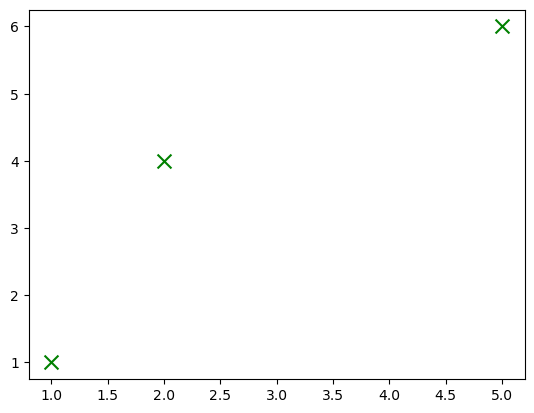

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class World:
    def __init__(self, world_size, landmarks):
        self.world_size = world_size
        self.landmarks = landmarks
        self.fig, self.ax = plt.subplots()
        self.particles_scatter = self.ax.scatter([], [], c='b', s=30, marker='o', alpha=0.5)
        self.robot_scatter = self.ax.scatter([], [], c='r', s=100, marker='^')
        self.landmarks_scatter = self.ax.scatter(landmarks[:, 0], landmarks[:, 1], c='g', s=100, marker='x')

    def draw(self, particles):
        self.ax.clear()
        self.ax.set_xlim(0, self.world_size)
        self.ax.set_ylim(0, self.world_size)

        # 他の描画処理（ランドマークやパーティクルの描画など）を実装する

        self.ax.scatter(particles[:, 0], particles[:, 1], c='b', s=30, marker='o', alpha=0.5)
        estimated_pos = np.mean(particles[:, :2], axis=0)
        self.ax.scatter(estimated_pos[0], estimated_pos[1], c='r', s=100, marker='^')
        self.ax.scatter(self.landmarks[:, 0], self.landmarks[:, 1], c='g', s=100, marker='x')

world_size = 8
landmarks = np.array([[1, 1], [2, 4], [5, 6]])
world = World(world_size, landmarks)

# パーティクル数
N = 100

# パーティクルの初期化
particles = np.random.rand(N, 3) * world_size
particles[:, 2] *= 2 * np.pi  # 角度を設定

# アニメーションの初期化
def init():
    return world.particles_scatter, world.robot_scatter, world.landmarks_scatter

# アニメーションの更新
def update(frame):
    delta = np.array([0.1, 0.05, 0.01])  # 移動量
    noise_std = 0.05  # ノイズの標準偏差

    move_particles(delta, noise_std)
    weights = sensor_model(np.array([4, 3]), particles, noise_std)
    indices = np.random.choice(N, N, p=weights)
    particles[:] = particles[indices]

    world.draw(particles)
    return world.particles_scatter, world.robot_scatter

# アニメーションの実行
ani = FuncAnimation(world.fig, update, frames=range(100), init_func=init, blit=True, interval=200)
plt.show()


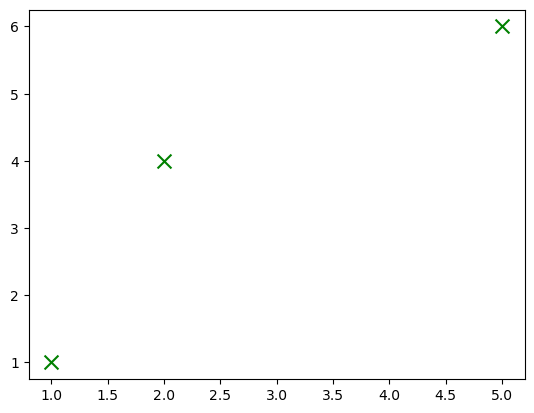

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class World:
    def __init__(self, world_size, landmarks):
        self.world_size = world_size
        self.landmarks = landmarks
        self.fig, self.ax = plt.subplots()
        self.particles_scatter = self.ax.scatter([], [], c='b', s=30, marker='o', alpha=0.5)
        self.robot_scatter = self.ax.scatter([], [], c='r', s=100, marker='^')
        self.landmarks_scatter = self.ax.scatter(landmarks[:, 0], landmarks[:, 1], c='g', s=100, marker='x')

    def draw(self, particles):
        self.ax.clear()
        self.ax.set_xlim(0, self.world_size)
        self.ax.set_ylim(0, self.world_size)

        # 他の描画処理（ランドマークやパーティクルの描画など）を実装する

        self.ax.scatter(particles[:, 0], particles[:, 1], c='b', s=30, marker='o', alpha=0.5)
        estimated_pos = np.mean(particles[:, :2], axis=0)
        self.ax.scatter(estimated_pos[0], estimated_pos[1], c='r', s=100, marker='^')
        self.ax.scatter(self.landmarks[:, 0], self.landmarks[:, 1], c='g', s=100, marker='x')

def move_particles(delta, noise_std):
    # パーティクルを移動させる処理を実装する
    pass

def sensor_model(sensor_pos, particles, noise_std):
    # センサーモデルを実装する
    pass

def observe_landmarks(particles, landmarks, noise_std):
    # ランドマークの観測を実装する
    pass

world_size = 8
landmarks = np.array([[1, 1], [2, 4], [5, 6]])
world = World(world_size, landmarks)

# パーティクル数
N = 100

# パーティクルの初期化
particles = np.random.rand(N, 3) * world_size
particles[:, 2] *= 2 * np.pi  # 角度を設定

# アニメーションの初期化
def init():
    return world.particles_scatter, world.robot_scatter, world.landmarks_scatter

# アニメーションの更新
def update(frame):
    delta = np.array([0.1, 0.05, 0.01])  # 移動量
    noise_std = 0.05  # ノイズの標準偏差

    move_particles(delta, noise_std)
    observe_landmarks(particles, landmarks, noise_std)
    weights = sensor_model(np.array([4, 3]), particles, noise_std)
    indices = np.random.choice(N, N, p=weights)
    particles[:] = particles[indices]

    world.draw(particles)
    return world.particles_scatter, world.robot_scatter

# アニメーションの実行
ani = FuncAnimation(world.fig, update, frames=range(100), init_func=init, blit=True, interval=200)
plt.show()


In [13]:
import sys                                   ###mcl1 全部のセルを掲載
sys.path.append('../scripts/')
from robot import *

ModuleNotFoundError: No module named 'robot'

In [14]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform


# In[2]:


class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval) 


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed


# In[4]:


if __name__ == '__main__': 
    world = World(30, 0.1, debug=False)  

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    r = Robot( np.array([ 2, 2, math.pi/6]).T, sensor=Camera(m, occlusion_prob=0.1), agent=circling) 
    world.append(r)

    ### アニメーション実行 ###
    world.draw()


# In[ ]:





ModuleNotFoundError: No module named 'ideal_robot'

In [15]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform


# In[2]:


class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval) 


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed


# In[4]:


if __name__ == '__main__': 
    world = World(30, 0.1, debug=False)  

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    r = Robot( np.array([ 2, 2, math.pi/6]).T, sensor=Camera(m, occlusion_prob=0.1), agent=circling) 
    world.append(r)

    ### アニメーション実行 ###
    world.draw()


# In[ ]:





ModuleNotFoundError: No module named 'ideal_robot'

<IPython.core.display.Javascript object>


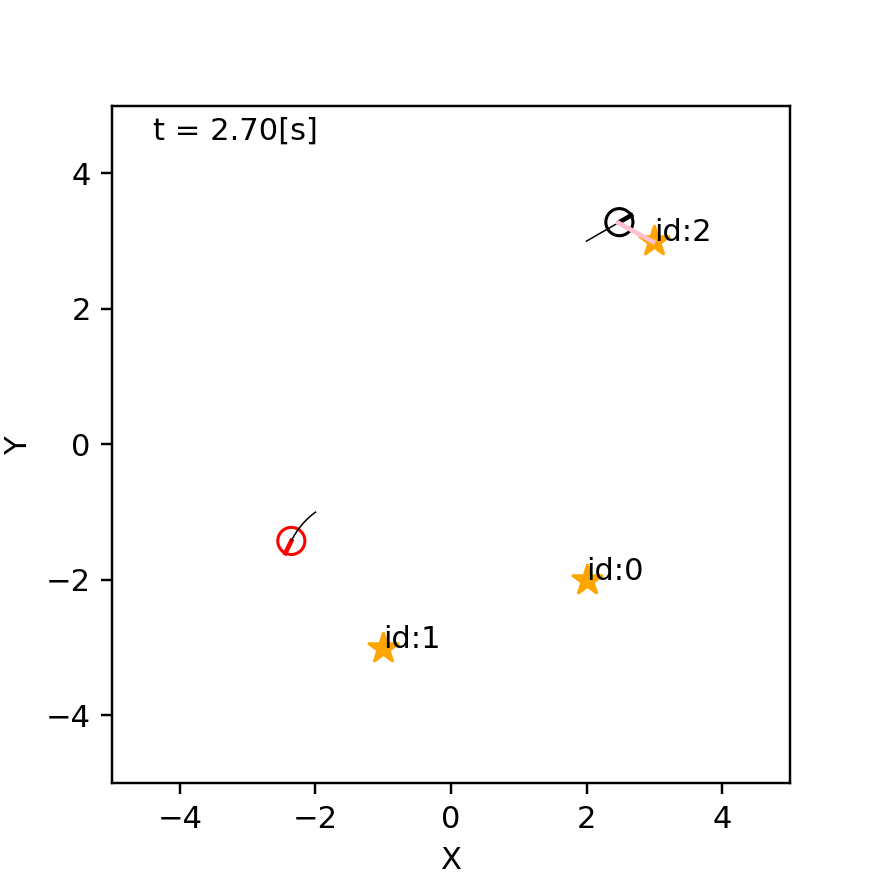

In [16]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np


# In[2]:


class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 
        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-5,5)                  
        ax.set_ylim(-5,5) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    


# In[3]:


class IdealRobot:   
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):         ### call_agent_draw
        x, y, theta = self.pose  
        xn = x + self.r * math.cos(theta)  
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1: 
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)
         
    @classmethod           
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return        
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)   


# In[4]:


class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega


# In[5]:


class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))


# In[6]:


class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)


# In[7]:


class IdealCamera:
    def __init__(self, env_map,                  distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]                 and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")


# In[8]:


if __name__ == '__main__':   ###name_indent
    world = World(30, 0.1) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(-1,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    sensor=IdealCamera(m), agent=straight )             # 引数にcameraを追加、整理
    robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), agent=circling, color="red")  # robot3は消しました
    world.append(robot1)
    world.append(robot2)

    ### アニメーション実行 ###
    world.draw()


In [17]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform


# In[2]:


class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval) 


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed


# In[4]:


if __name__ == '__main__': 
    world = World(30, 0.1, debug=False)  

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    r = Robot( np.array([ 2, 2, math.pi/6]).T, sensor=Camera(m, occlusion_prob=0.1), agent=circling) 
    world.append(r)

    ### アニメーション実行 ###
    world.draw()


# In[ ]:





ModuleNotFoundError: No module named 'ideal_robot'

<IPython.core.display.Javascript object>


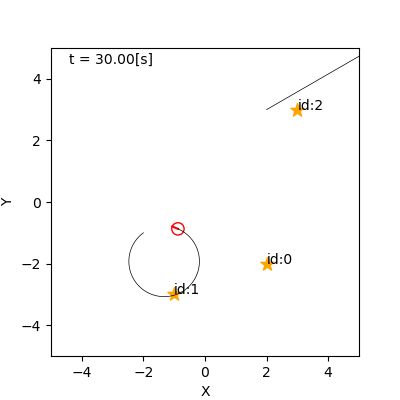

ModuleNotFoundError: No module named 'ideal_robot'

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np


# In[2]:


class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 
        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-5,5)                  
        ax.set_ylim(-5,5) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    


# In[3]:


class IdealRobot:   
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):         ### call_agent_draw
        x, y, theta = self.pose  
        xn = x + self.r * math.cos(theta)  
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1: 
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)
         
    @classmethod           
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return        
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)   


# In[4]:


class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega


# In[5]:


class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))


# In[6]:


class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)


# In[7]:


class IdealCamera:
    def __init__(self, env_map,                  distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]                 and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")


# In[8]:


if __name__ == '__main__':   ###name_indent
    world = World(30, 0.1) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(-1,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    sensor=IdealCamera(m), agent=straight )             # 引数にcameraを追加、整理
    robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), agent=circling, color="red")  # robot3は消しました
    world.append(robot1)
    world.append(robot2)

    ### アニメーション実行 ###
    world.draw()

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm, uniform


# In[2]:


class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval) 


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed


# In[4]:


if __name__ == '__main__': 
    world = World(30, 0.1, debug=False)  

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    r = Robot( np.array([ 2, 2, math.pi/6]).T, sensor=Camera(m, occlusion_prob=0.1), agent=circling) 
    world.append(r)

    ### アニメーション実行 ###
    world.draw()


# In[ ]:



    

<IPython.core.display.Javascript object>


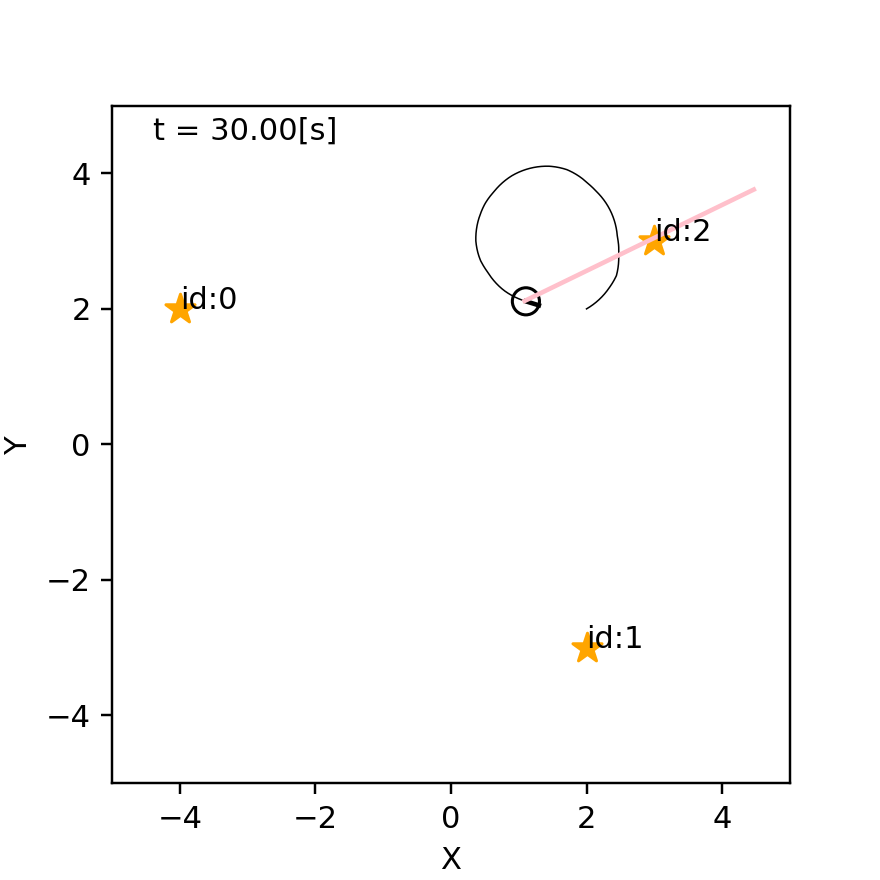

In [19]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys                       
sys.path.append('../scripts/')

from scipy.stats import expon, norm, uniform


# In[2]:


class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
            
    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval) 


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
            
        self.lastdata = observed 
        return observed


# In[4]:


if __name__ == '__main__': 
    world = World(30, 0.1, debug=False)  

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    r = Robot( np.array([ 2, 2, math.pi/6]).T, sensor=Camera(m, occlusion_prob=0.1), agent=circling) 
    world.append(r)

    ### アニメーション実行 ###
    world.draw()


# In[ ]:





In [9]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

class EstimationAgent(Agent):
    def __init__(self, nu, omega):
        super().__init__(nu, omega)
        
    def draw(self, ax, elems):
        elems.append(ax.text(0, 0, "hoge", fontsize=10))

world = World(30, 0.1)  

### 地図を生成して3つランドマークを追加 ###
m = Map()
for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
world.append(m)          

### ロボットを作る ###
initial_pose = np.array([2, 2, math.pi/6]).T
circling = EstimationAgent(0.2, 10.0/180*math.pi) 
r = Robot(initial_pose, sensor=Camera(m), agent=circling) 
world.append(r)

### アニメーション実行 ###
world.draw()

NameError: name 'Robot' is not defined